## EE4540 - Distributed Signal Processing - Course Project
Nishita Anand, Rubhav Nayak

### Question 1: 

Design a proper connected sensor network that covers the area of the plant by using a
reasonable number of sensors. How many do we need to guarantee a connected sensor
network? Motivate your choice.

In [43]:
# This is done by using a Random Geometric Graph
#Reference: 
# 1. https://academic.oup.com/book/9064?login=true
# 2. https://arxiv.org/pdf/1207.2573: formulation for the radius

#https://dl.acm.org/doi/pdf/10.1145/958491.958496

In [44]:
# Import Libraries

from numpy import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

In [45]:
# Essential Functions

# Function to calculate adjacency matrix
def calculate_adjacency_matrix(agent_locations, communication_range):
    num_agents = agent_locations.shape[1]
    adjacency_matrix = np.zeros((num_agents, num_agents), dtype=int)

    for i in range(num_agents):
        for j in range(num_agents):
            if i != j:  # to avoid self-loops
                distance = np.linalg.norm(agent_locations[:, i] - agent_locations[:, j])
                if distance <= communication_range:
                    adjacency_matrix[i, j] = 1

    return adjacency_matrix

# Function to check graph connectivity
def is_graph_connected(adjacency_matrix):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix
    eigenvalues = np.linalg.eigvalsh(laplacian_matrix)
    zero_eigenvalues = np.sum(np.isclose(eigenvalues, 0))
    return zero_eigenvalues == 1

# Function to create transition matrix P
def generate_uniform_P(adjacency_matrix):
    n = adjacency_matrix.shape[0]
    P = np.zeros((n, n), dtype=float)

    for i in range(n):
        neighbors = np.where(adjacency_matrix[i] == 1)[0]
        degree = len(neighbors)
        if degree > 0:
            P[i, neighbors] = 1.0 / degree  # Uniform distribution over neighbors
        # If no neighbors, row stays all zero (won't be used anyway)

    return P


Is network connected? True


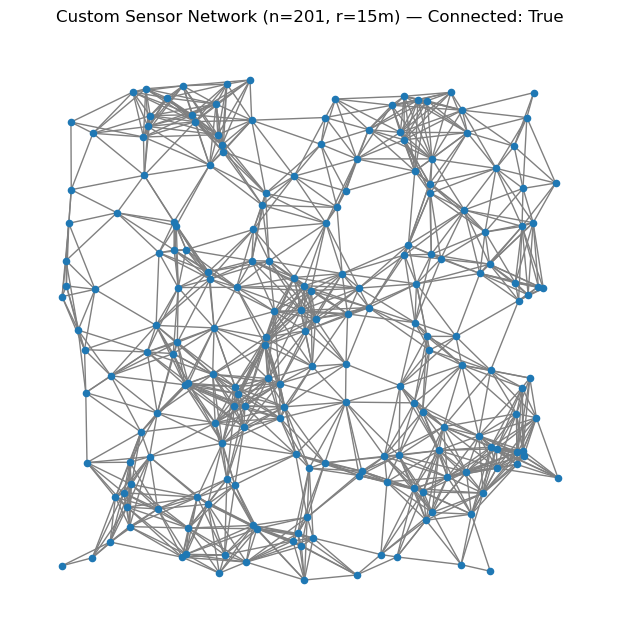

In [46]:
# === Parameters ===
n = 201
area_size = 100
r = 15

# === Generate sensor locations as [2, n] array ===
np.random.seed(50)
positions = np.random.uniform(0, area_size, (n, 2)).T  # shape: [2, n]



# === Calculate adjacency matrix and check connectivity ===
adj_matrix = calculate_adjacency_matrix(positions, r)
connected = is_graph_connected(adj_matrix)

# === Print result ===
print(f"Is network connected? {connected}")

# === Visualize using networkx ===
G = nx.from_numpy_array(adj_matrix)
pos_dict = {i: positions[:, i] for i in range(n)}

plt.figure(figsize=(6,6))
nx.draw(G, pos=pos_dict, node_size=20, edge_color='gray')
plt.title(f"Custom Sensor Network (n={n}, r={r}m) — Connected: {connected}")
plt.axis('equal')
plt.grid(True)
plt.show()

# === Generating values for each node/sensor ===

np.random.seed(50) # Constant seed for reproducibility
sensor_values=np.random.randint(0, 100, (n, 1))


### Question 2

Suppose the sensor network would like to compute the average value of the
measurement data. In addition to a randomised gossip implementation, which will
serve as a baseline method, implement the average consensus problem using the
PDMM algorithm. Report the performance in terms of convergence speed and number
of transmissions and compare this to the results obtained by the randomised gossip
algorithm.

Part 1: Randomized Gossip

In [47]:
def randomized_gossip_average_consensus(
    adj_matrix, 
    sensor_values, 
    iters=500000, 
    epsilon=1e-29, 
    p_fail=0.0, 
    seed=None,
    verbose=True
):

    if seed is not None:
        np.random.seed(seed)
    
    n = len(sensor_values)
    sensor_values_rg = sensor_values.copy().astype(float)
    avg = np.mean(sensor_values_rg)
    avg_vec = avg * np.ones(n)
    error_rg = []

    t_start = time.perf_counter()

    for step in range(iters):
        i = np.random.randint(0, n)  # pick random node

        neighbors = []
        for k in range(n):
            if adj_matrix[i, k] == 1:
                neighbors.append(k)

        if len(neighbors) == 0:
            continue

        j = neighbors[np.random.randint(0, len(neighbors))]

        # --- TRANSMISSION FAILURE: Skip update with probability p_fail ---
        if np.random.rand() > p_fail:
            x_ij_avg = 0.5 * (sensor_values_rg[i] + sensor_values_rg[j])
            sensor_values_rg[i] = x_ij_avg
            sensor_values_rg[j] = x_ij_avg
        # else: update skipped (values unchanged)

        diff = sensor_values_rg - avg_vec
        squared_error = np.mean(diff**2)
        error_rg.append(squared_error)

        if squared_error < epsilon:
            t_end = time.perf_counter()
            elapsed = t_end - t_start
            if verbose:
                print(f"Stopped at step {step+1} with error {squared_error:.2e}")
                print(f"Elapsed time: {elapsed:.4f} seconds")
            return error_rg, step+1, elapsed

    t_end = time.perf_counter()
    elapsed = t_end - t_start
    if verbose:
        print(f"Ran full {iters} steps. Final error: {squared_error:.2e}")
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return error_rg, elapsed


Ran full 500000 steps. Final error: 6.12e-28
Elapsed time: 89.5498 seconds


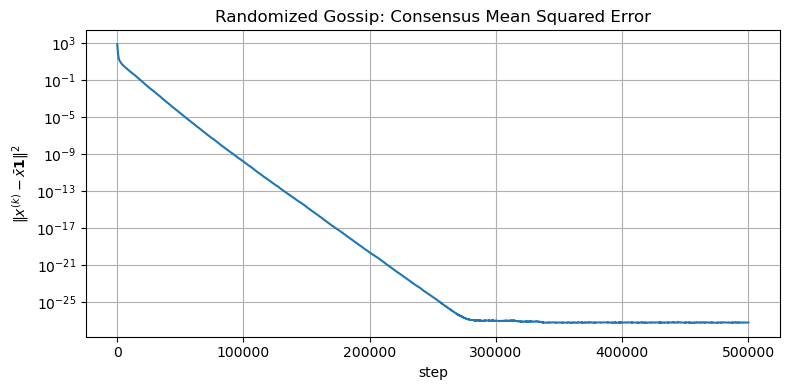

In [48]:
# Plot Randomized Gossip Results
error_rg, elapsed = randomized_gossip_average_consensus(adj_matrix, sensor_values, iters=500000, seed=50)

plt.figure(figsize=(8, 4))
plt.semilogy(error_rg)
plt.xlabel("step")
plt.ylabel(r"$\|x^{(k)} - \bar{x}\mathbf{1}\|^2$")
plt.title("Randomized Gossip: Consensus Mean Squared Error")
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# Construct Expected Weight Matrix E[W]

P = generate_uniform_P(adj_matrix)
n = P.shape[0]
W_expected = np.zeros((n, n))
I = np.eye(n)

for i in range(n):
    for j in range(n):
        if P[i, j] > 0:
            v = np.zeros((n, 1))
            v[i] = 1
            v[j] = -1
            Wij = I - 0.5 * (v @ v.T)
            W_expected += (1 / n) * P[i, j] * Wij

print(W_expected)
np.shape(W_expected)

[[9.95334043e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.94860400e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.96044308e-01 ... 0.00000000e+00
  0.00000000e+00 4.66417910e-04]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.94486764e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.95139686e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.66417910e-04 ... 0.00000000e+00
  0.00000000e+00 9.94190203e-01]]


(201, 201)

Part 2: Average Consensus using PDMM

In [50]:
def pdmm_average_consensus(
    adj_matrix,
    sensor_values,
    c=0.256,
    iters=500,
    p_fail=0.0,
    seed=None,
    verbose=True
):
    
    if seed is not None:
        np.random.seed(seed)

    n = len(sensor_values)
    sensor_values_pdmm_avg = sensor_values.copy().astype(float)
    true_average = np.mean(sensor_values_pdmm_avg)

    x = sensor_values_pdmm_avg.astype(float).copy()
    z = {}
    # Initialize dual variables for all edges
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] == 1:
                z[(i, j)] = 0.0

    x_history = [x.copy()]
    error_ac = [np.mean((x - true_average)**2)]

    t_start = time.perf_counter()

    for k in range(iters):
        x_new = x.copy()

        # For this iteration, decide transmission for all edges
        trans_success = {}
        for i in range(n):
            for j in range(n):
                if adj_matrix[i, j] == 1:
                    trans_success[(i, j)] = np.random.rand() > p_fail

        # Primal update
        for i in range(n):
            neighbors = [j for j in range(n) if adj_matrix[i, j] == 1 and trans_success[(i, j)]]
            d = len(neighbors)
            if d > 0:
                sum_z = sum(z[(i, j)] for j in neighbors)
                x_new[i] = (sensor_values_pdmm_avg[i] - sum_z) / (1 + c * d)
            # else: If no neighbors succeeded, keep x[i] unchanged

        # Partial update y (use only successful edges)
        y = {}
        for i in range(n):
            for j in range(n):
                if adj_matrix[i, j] == 1 and trans_success[(i, j)]:
                    y[(i, j)] = z[(i, j)] + 2 * c * x_new[i]

        # Flip step (only if both directions succeeded)
        for i in range(n):
            for j in range(n):
                if adj_matrix[i, j] == 1:
                    if trans_success[(i, j)] and trans_success.get((j, i), False):
                        z[(j, i)] = -y[(i, j)]
                    # else: do not update z[(j, i)]

        x = x_new.copy()
        x_history.append(x.copy())
        error_ac.append(np.mean((x - true_average)**2))

    t_end = time.perf_counter()
    elapsed = t_end - t_start
    if verbose:
        print(f"Elapsed time: {elapsed:.4f} seconds")

    return x_history, error_ac, elapsed

Elapsed time: 134.5505 seconds


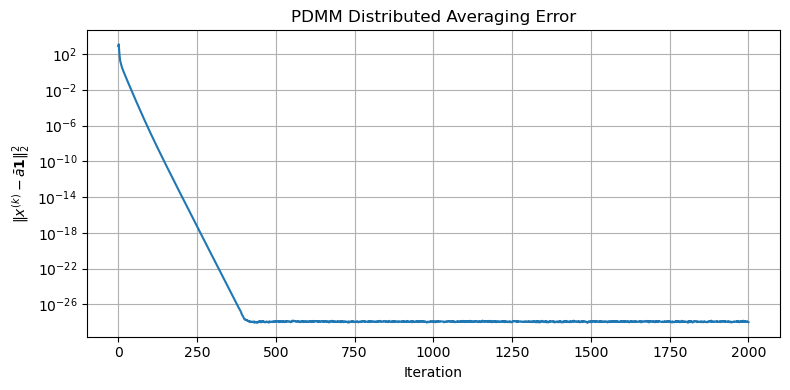

Final error: 1.01e-28
Elapsed time: 134.5505 seconds


In [51]:
# Plot PDMM Average Consensus Results

x_history, error_ac, elapsed = pdmm_average_consensus(adj_matrix, sensor_values, c=0.256, iters=2000, seed=50)


plt.figure(figsize=(8, 4))
plt.semilogy(error_ac)
plt.xlabel("Iteration")
plt.ylabel(r"$\|x^{(k)} - \bar{a}\mathbf{1}\|_2^2$")
plt.title("PDMM Distributed Averaging Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final results ===
print(f"Final error: {error_ac[-1]:.2e}")
print(f"Elapsed time: {elapsed:.4f} seconds")


### Question 3

Suppose the sensor network would like to compute the median of the measurement
data. Implement the median consensus problem using the PDMM algorithm.

Median Consensus Using PDMM

In [53]:
def pdmm_median_consensus(
    adj_matrix,
    sensor_values,
    c=1.09,
    iters=20000,
    p_fail=0.0,
    seed=None,
    verbose=True
):

    if seed is not None:
        np.random.seed(seed)

    G = nx.from_numpy_array(adj_matrix)
    n = len(sensor_values)
    neighbors = {i: list(G.neighbors(i)) for i in G.nodes()}
    degrees = np.array([len(neighbors[i]) for i in range(n)])

    s = sensor_values.flatten()
    true_med = np.median(s)

    # Initialization
    x = s.astype(float).copy()
    z = {(i, j): 0.0 for i in G for j in neighbors[i]}
    error_mc = []

    t_start = time.perf_counter()

    for k in range(iters):
        x_new = np.zeros_like(x)

        # Transmission mask per edge
        trans_success = {(i, j): (np.random.rand() > p_fail) for i in G for j in neighbors[i]}

        # Primal update
        for i in range(n):
            di = degrees[i]
            if di == 0:
                x_new[i] = s[i]
                continue
            
            # Only sum over successful transmissions
            sum_z = sum(
                (1 if i < j else -1) * z[(i, j)]
                for j in neighbors[i]
                if trans_success[(i, j)]
            )
            
            # Use the number of *successful* neighbors
            di_eff = sum(trans_success[(i, j)] for j in neighbors[i])
            if di_eff == 0:
                x_new[i] = x[i]  # No update if all comm failed
                continue

            bound_1 = (1 - sum_z) / (c * di_eff)
            bound_2 = (-1 - sum_z) / (c * di_eff)

            lower_bound = min(bound_1, bound_2)
            upper_bound = max(bound_1, bound_2)

            if s[i] < lower_bound:
                x_new[i] = lower_bound
            elif s[i] > upper_bound:
                x_new[i] = upper_bound
            else:
                x_new[i] = s[i]

        # Dual variable update
        old_z = z.copy()
        for i in range(n):
            for j in neighbors[i]:
                # Only update if BOTH directions succeed
                if trans_success[(i, j)] and trans_success.get((j, i), False):
                    A_ij = 1 if i < j else -1
                    z[(j, i)] = 0.5 * old_z[(j, i)] + 0.5 * (old_z[(i, j)] + 2 * c * A_ij * x_new[i])
                # else: z[(j, i)] stays the same

        x = x_new
        error_mc.append(np.mean((x - true_med) ** 2))

    t_end = time.perf_counter()
    elapsed = t_end - t_start
    if verbose:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return x, error_mc, elapsed

Elapsed time: 125.4791 seconds


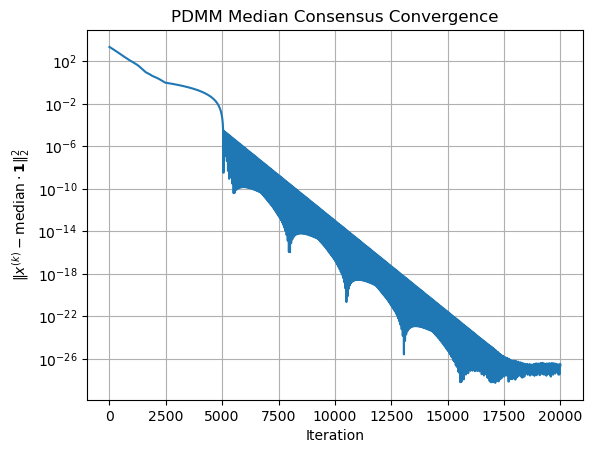

Final error: 2.262876941734876e-27


In [55]:
# Plot Median Consensus

x_history, error_mc, elapsed = pdmm_median_consensus(adj_matrix, sensor_values, c=1.09, iters=20000, seed=50)

plt.semilogy(error_mc)
plt.xlabel('Iteration')
plt.ylabel(r"$\|x^{(k)} - \mathrm{median}\cdot\mathbf{1}\|_2^2$")
plt.title('PDMM Median Consensus Convergence')
plt.grid(True)
plt.show()

print(f"Final error: {error_mc[-1]}")

### 
Hyperparameter Optimization with different values of 'c'

In [ ]:
c_values = np.linspace(0.1, 1.5, 15)
errors_vs_c = []
final_errors = []

for c in c_values:
    x_hist, error_ac, elapsed = pdmm_average_consensus(adj_matrix, sensor_values, c=c, iters=2000, seed=50, verbose=False)
    errors_vs_c.append(error_ac)
    final_errors.append(error_ac[-1])

# === Plot convergence for different c ===
plt.figure(figsize=(8,5))
for idx, c in enumerate(c_values):
    plt.semilogy(errors_vs_c[idx], label=f"c={c:.2f}")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("PDMM Convergence vs. c")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Report best c
best_c_idx = np.argmin(final_errors)
print(f"Best c is {c_values[best_c_idx]:.3f} with final error {final_errors[best_c_idx]:.2e}")

In [ ]:
c_values = np.linspace(0.1, 1.5, 10)
errors_vs_c = []
final_errors = []

iters = 20000  # You can increase for smoother curves

for c in c_values:
    # Call your function (no need to manually re-initialize anything)
    x_final, error_mc, elapsed = pdmm_median_consensus(adj_matrix, sensor_values, c=c, iters=iters, seed=50, verbose=False)
    errors_vs_c.append(error_mc)
    final_errors.append(error_mc[-1])

# === Plot convergence for different c
plt.figure(figsize=(8, 5))
for idx, c in enumerate(c_values):
    plt.semilogy(errors_vs_c[idx], label=f"c={c:.2f}")
plt.xlabel("Iterations")
plt.ylabel(r"$\frac{1}{n}\|x^{(k)} - \mathrm{median}\cdot\mathbf{1}\|_2^2$")
plt.title("PDMM Median Consensus: Convergence vs. c")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Report best c
best_c_idx = np.argmin(final_errors)
print(f"Best c is {c_values[best_c_idx]:.3f} with final error {final_errors[best_c_idx]:.2e}")


###
Comparing Convergence Rates across PDMM algorithms

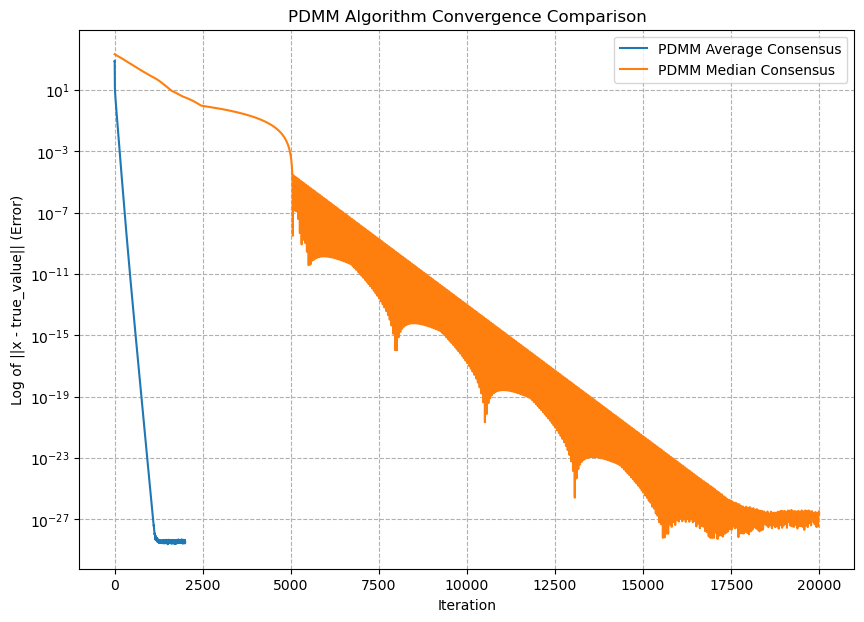

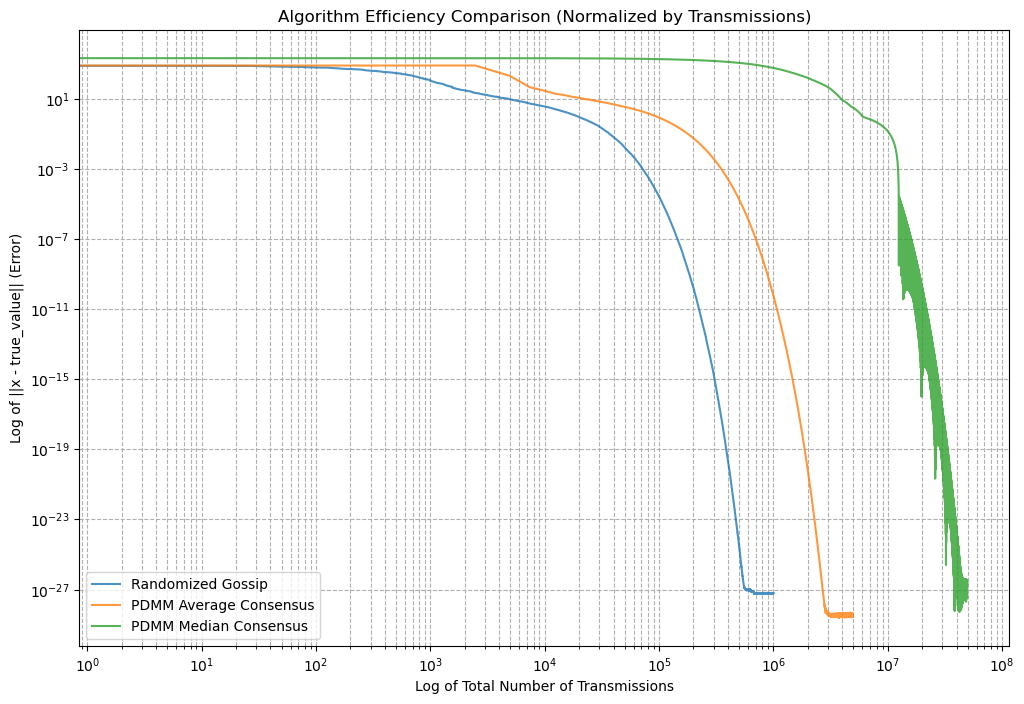

In [56]:
# --- PLOT 1: COMPARING PDMM ALGORITHMS ---

plt.figure(figsize=(10, 7))

# Only plot the two PDMM error histories
plt.semilogy(error_ac, label='PDMM Average Consensus')
plt.semilogy(error_mc, label='PDMM Median Consensus')

plt.title('PDMM Algorithm Convergence Comparison')
plt.xlabel('Iteration')
plt.ylabel('Log of ||x - true_value|| (Error)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
# --- PLOT 2: NORMALIZED BY NUMBER OF TRANSMISSIONS ---

# Calculate the number of edges in the graph
num_edges = G.number_of_edges()

# Create the x-axis arrays for transmissions
transmissions_rg = np.arange(len(error_rg)) * 2  # 2 transmissions per gossip iteration
transmissions_pdmm_ac = np.arange(len(error_ac)) * (2 * num_edges) # 2*|E| transmissions per PDMM iteration
transmissions_pdmm_mc = np.arange(len(error_mc)) * (2 * num_edges)

plt.figure(figsize=(12, 8))

# Plot error vs. number of transmissions
# Use a log-log plot here to handle the very large x-axis range for transmissions
plt.loglog(transmissions_rg, error_rg, label='Randomized Gossip', alpha=0.8)
plt.loglog(transmissions_pdmm_ac, error_ac, label='PDMM Average Consensus', alpha=0.8)
plt.loglog(transmissions_pdmm_mc, error_mc, label='PDMM Median Consensus', alpha=0.8)

plt.title('Algorithm Efficiency Comparison (Normalized by Transmissions)')
plt.xlabel('Log of Total Number of Transmissions')
plt.ylabel('Log of ||x - true_value|| (Error)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

### Transmission Failures

A transmission failure occurs when one node is unable to send data to the next node. This can happen due to a number of factors, both external and internal, and good distributed algorithms account for such failures. Here, we will simulate what the errors look like with various transmission errors.

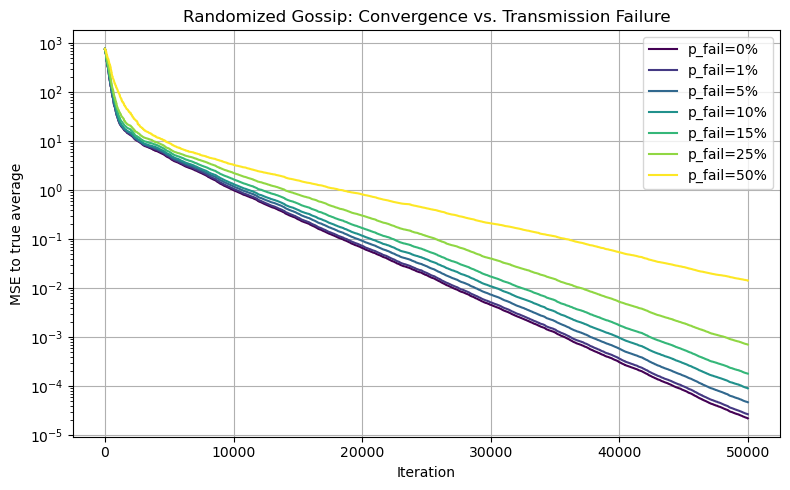

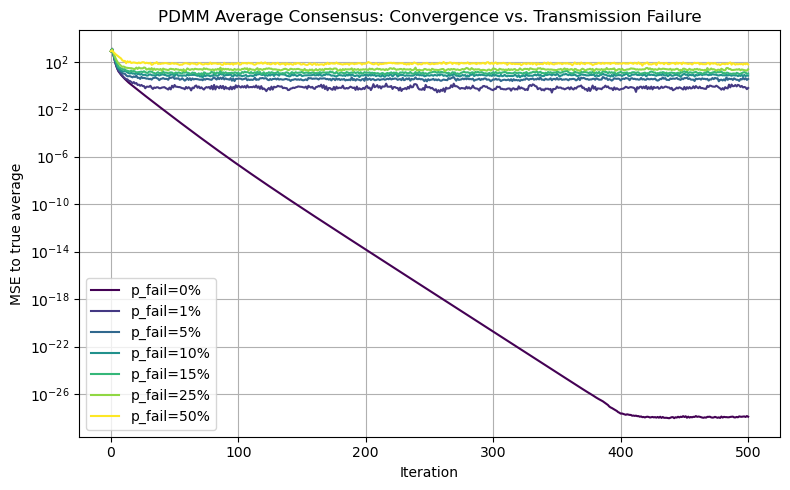

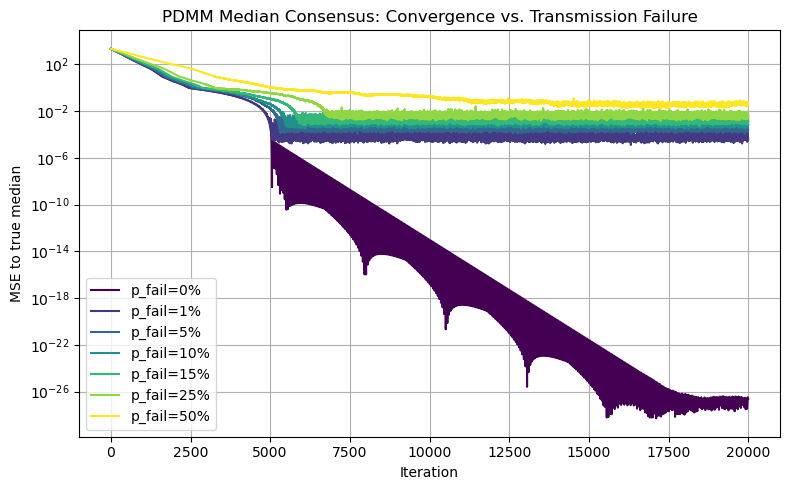

In [58]:
failure_rates = [0, 0.01, 0.05, 0.10, 0.15, 0.25, 0.5]
color_cycle = plt.cm.viridis(np.linspace(0, 1, len(failure_rates)))

# --- 1. Randomized Gossip ---
gossip_errors = []
for pf in failure_rates:
    errors, elapsed = randomized_gossip_average_consensus(
        adj_matrix,
        sensor_values,
        iters=50000,   # Default (shorten if needed for speed)
        epsilon=1e-10,
        p_fail=pf,
        seed=0,
        verbose=False
    )
    gossip_errors.append(errors)

plt.figure(figsize=(8,5))
for idx, pf in enumerate(failure_rates):
    plt.semilogy(gossip_errors[idx], label=f"p_fail={100*pf:.0f}%", color=color_cycle[idx])
plt.xlabel("Iteration")
plt.ylabel(r"MSE to true average")
plt.title("Randomized Gossip: Convergence vs. Transmission Failure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. PDMM Average Consensus ---
pdmm_avg_errors = []
for pf in failure_rates:
    x_hist, errors, elapsed = pdmm_average_consensus(
        adj_matrix,
        sensor_values,
        c=0.256,
        iters=500,
        p_fail=pf,
        seed=0,
        verbose=False
    )
    pdmm_avg_errors.append(errors)

plt.figure(figsize=(8,5))
for idx, pf in enumerate(failure_rates):
    plt.semilogy(pdmm_avg_errors[idx], label=f"p_fail={100*pf:.0f}%", color=color_cycle[idx])
plt.xlabel("Iteration")
plt.ylabel(r"MSE to true average")
plt.title("PDMM Average Consensus: Convergence vs. Transmission Failure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. PDMM Median Consensus ---
pdmm_median_errors = []
for pf in failure_rates:
    x_final, errors, elapsed = pdmm_median_consensus(
        adj_matrix,
        sensor_values,
        c=1.09,
        iters=20000,
        p_fail=pf,
        seed=0,
        verbose=False
    )
    pdmm_median_errors.append(errors)

plt.figure(figsize=(8,5))
for idx, pf in enumerate(failure_rates):
    plt.semilogy(pdmm_median_errors[idx], label=f"p_fail={100*pf:.0f}%", color=color_cycle[idx])
plt.xlabel("Iteration")
plt.ylabel(r"MSE to true median")
plt.title("PDMM Median Consensus: Convergence vs. Transmission Failure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Recycle Bin

In [ ]:
# Alternate Version of Median Consensus Code

# === Prepare PDMM variables ===
A_matrix = (adj_matrix > 0).astype(int)  # binary adjacency matrix
x_local = sensor_values.flatten()                 # local data at each node (x coordinate)
med = np.median(x_local)                  # true median for tracking error

# === PDMM for median finding ===
tm0 = time.perf_counter()
conv = False
eps = 1e-29

x_val = np.zeros(n)
c = 1.09
z = np.zeros((n, n))  # store z_ij and z_ji
errors = []
am = -1

for iteration in range(20000):  # number of overall iterations
    for i in range(n):  # for each node
        # Get neighbors
        neighbors = np.where(A_matrix[i] == 1)[0]
        z_sum = 0

        for j in neighbors:
            a = -1 if j > i else 1
            z_sum += a * z[i, j]

        d = len(neighbors)

        x1 = (-1 - z_sum) / (c * d)
        x2 = (1 - z_sum) / (c * d)

        if x1 > x_local[i]:
            x_val[i] = x1
        elif x2 < x_local[i]:
            x_val[i] = x2
        else:
            x_val[i] = x_local[i]

        for j in neighbors:
            a = -1 if j > i else 1
            z[j, i] = z[j, i] / 2 + (z[i, j] + 2 * a * x_val[i] * c) / 2

    # Track error (MSE w.r.t. true median)
    am += 1
    errors.append(np.mean((x_val - med)**2))

    if not conv and errors[am] < eps:
        conv = True
        tm1 = time.perf_counter()
        elapsed = tm1 - tm0
        print(f"number of iterations needed for convergence = {am}")
        print(f"elapsed time = {elapsed:.4f} seconds")

# === Plot convergence ===
plt.figure()
plt.semilogy(errors)
plt.xlabel('Iteration')
plt.ylabel('MSE Error (log scale)')
plt.title('Convergence of Alternate PDMM')
plt.show()


In [ ]:
# Randomized Gossip Implementation to compute average value of measurement data

sensor_values_rg = sensor_values.copy().astype(float) #making a copy for each algorithm
avg = np.mean(sensor_values_rg)
avg_vec = avg * np.ones((n, 1))
error_rg = []

time_steps=500000
epsilon= 10e-30

tm0 = time.perf_counter()

for step in range(time_steps):
    
    i = np.random.randint(0, n)  # pick random node
    
    neighbors = []
    for k in range(n):
        if adj_matrix[i, k] == 1:
            neighbors.append(k)

    if len(neighbors) == 0:
        continue

    j = neighbors[np.random.randint(0, len(neighbors))]

    # Compute average and update both i and j
    x_ij_avg = 0.5 * (sensor_values_rg[i] + sensor_values_rg[j])
    sensor_values_rg[i] = x_ij_avg
    sensor_values_rg[j] = x_ij_avg

    # Compute MSE from average consensus
    diff = sensor_values_rg - avg_vec
    squared_error = np.mean(diff**2)
    error_rg.append(squared_error)

    if squared_error < epsilon:
        tm1 = time.perf_counter()
        elapsed = tm1 - tm0
        print(f"Stopped at step {step+1} with error {squared_error:.2e}")
        print(f"Elapsed time: {elapsed:.4f} seconds")
        break

else:
    tm1 = time.perf_counter()
    elapsed = tm1 - tm0
    print(f"Ran full {time_steps} steps. Final error: {squared_error:.2e}")
    print(f"Elapsed time: {elapsed:.4f} seconds")

plt.figure(figsize=(8, 4))
plt.semilogy(error_rg)
plt.xlabel("step")
plt.ylabel(r"$\|x^{(k)} - \bar{x}\mathbf{1}\|^2$")
plt.title("Randomized Gossip: Consensus Mean Squared Error (Log Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Average Consensus Implementation using PDMM

sensor_values_pdmm_avg = sensor_values.copy().astype(float) #making a copy for each algorithm

true_average = np.mean(sensor_values_pdmm_avg)
c = 0.256
iterations = 500

x = sensor_values_pdmm_avg.astype(float).copy()
z = {}  # dual variables

# Initialize dual variables for all edges
for i in range(n):
    for j in range(n):
        if adj_matrix[i, j] == 1:
            z[(i, j)] = 0.0

x_history = [x.copy()]
error_ac = [np.mean((x - true_average)**2)]

tm0 = time.perf_counter()  # Start timing

for k in range(iterations):
    x_new = x.copy()

    # Primal update
    for i in range(n):
        neighbors = [j for j in range(n) if adj_matrix[i, j] == 1]
        d = len(neighbors)
        sum_z = sum(z[(i, j)] for j in neighbors)
        x_new[i] = (sensor_values_pdmm_avg[i] - sum_z) / (1 + c * d)

    # Partial update y
    y = {}
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] == 1:
                y[(i, j)] = z[(i, j)] + 2 * c * x_new[i]

    # Flip step
    for i in range(n):
        for j in range(n):
            if adj_matrix[i, j] == 1:
                z[(j, i)] = -y[(i, j)]

    x = x_new.copy()
    x_history.append(x.copy())
    error_ac.append(np.mean((x - true_average)**2))

tm1 = time.perf_counter()  # Stop timing
elapsed = tm1 - tm0

# === Plotting ===
plt.figure(figsize=(8, 4))
plt.semilogy(error_ac)
plt.xlabel("Iteration")
plt.ylabel(r"$\|x^{(k)} - \bar{a}\mathbf{1}\|_2^2$")
plt.title("PDMM Distributed Averaging Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final results ===
print(f"Final error: {error_ac[-1]:.2e}")
print(f"Elapsed time: {elapsed:.4f} seconds")
print("Final consensus values (first 10):", np.round(x[:10], 4))
print("True average:", round(true_average, 4))


In [ ]:
# --- PDMM MEDIAN CONSENSUS ---

# Use the original 0/1 adjacency matrix to create the graph
G = nx.from_numpy_array(adj_matrix)
neighbors = {i: list(G.neighbors(i)) for i in G.nodes()}
degrees = np.array([len(neighbors[i]) for i in range(n)])

# Set parameters
c = 1.09
iters = 20000

s = sensor_values.flatten()  # private scalar at each node
true_med = np.median(s)

# 1) Initialization
x = s.astype(float).copy()
# Duals z_{i|j} are associated with node i's view of the edge (i,j)
z = {(i, j): 0.0 for i in G for j in neighbors[i]}

error_mc = []

# --- PDMM Iterations ---
for k in range(iters):
    x_new = np.zeros_like(x)

    # --- CORRECTED PRIMAL UPDATE ---
    # Implements the three-case function from Eq. (4) with the correct A_ij sign convention
    for i in range(n):
        di = degrees[i]
        if di == 0:
            x_new[i] = s[i]
            continue
        
        # This sum now correctly includes the A_ij sign
        sum_z = sum((1 if i < j else -1) * z[(i, j)] for j in neighbors[i])

        # Define the interval boundaries from Algorithm 1
        bound_1 = (1 - sum_z) / (c * di)
        bound_2 = (-1 - sum_z) / (c * di)

        lower_bound = min(bound_1, bound_2)
        upper_bound = max(bound_1, bound_2)
        
        # Apply the three-case clipping rule
        if s[i] < lower_bound:
            x_new[i] = lower_bound
        elif s[i] > upper_bound:
            x_new[i] = upper_bound
        else:
            x_new[i] = s[i]

    # Implements the Averaged PDMM update from Eq. (5) with the correct A_ij sign convention
    old_z = z.copy() 
    for i in range(n):
        for j in neighbors[i]:
            # Define A_ij based on the paper's convention
            A_ij = 1 if i < j else -1
            
            # Update the dual variable at node j for the edge coming from i
            # This implements z_{j|i}^{(t+1)} = (1-θ)z_{j|i} + θ * y_{i|j}, with θ=1/2
            # and y_{i|j} = z_{i|j} + 2c*A_ij*x_i
            # Note: The update for z[(j, i)] depends on x_new[i]
            z[(j, i)] = 0.5 * old_z[(j, i)] + 0.5 * (old_z[(i, j)] + 2 * c * A_ij * x_new[i])
            

    
    x = x_new
    error_mc.append(np.mean((x - true_med)**2))


# --- Plot convergence and show results ---
plt.semilogy(error_mc)
plt.xlabel('Iteration')
plt.ylabel('||x - true_median||')
plt.title('PDMM Median Consensus Convergence')
plt.grid(True)
plt.show()

print(f"Final error: {error_mc[-1]}")
print(f"Final node estimates (first 10): {x[:10]}")
print(f"True median: {true_med}")